In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [70]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense,Flatten
from keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from keras.preprocessing import image
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [66]:
# # Define the source directory and target directory
# source_dir = '/content/drive/MyDrive/Colab Notebooks/Breast_Cancer'  # Set this to your dataset directory
# target_dir = '/content/drive/MyDrive/Colab Notebooks/Breast_Cancer'  # Directory where you want to store the images

# # Create target directories if they don't exist
# os.makedirs(os.path.join(target_dir, '0'), exist_ok=True)
# os.makedirs(os.path.join(target_dir, '1'), exist_ok=True)

# # Walk through the source directory
# for patient_folder in os.listdir(source_dir):
#     patient_path = os.path.join(source_dir, patient_folder)
#     if os.path.isdir(patient_path):  # Ensure it's a directory
#         for label in ['0', '1']:  # Loop through the two label folders
#             label_path = os.path.join(patient_path, label)
#             if os.path.isdir(label_path):  # Check if the label folder exists
#                 # Move all images from label folder to the target directory
#                 for image in os.listdir(label_path):
#                     src_image_path = os.path.join(label_path, image)
#                     dst_image_path = os.path.join(target_dir, label, image)
#                     shutil.move(src_image_path, dst_image_path)
#                     print(f'Moved: {src_image_path} to {dst_image_path}')


## PreProcessing Data

In [67]:
# Define paths
data_dir = '/content/drive/MyDrive/Colab Notebooks/Breast_Cancer'  # Set this to your dataset directory

# Create ImageDataGenerator for training and testing with rescaling
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # 20% for validation/testing
)

In [68]:
train_generator = datagen.flow_from_directory(
    data_dir,  # Keep original image size
    batch_size=32,  # Set batch size
    class_mode='binary',  # Since we have 0 and 1 labels
    subset='training',  # Use the training split
    shuffle=True,
    seed=42  # Setting a seed for reproducibility
)

Found 61429 images belonging to 2 classes.


In [69]:
# Load testing data (20%)
validation_generator = datagen.flow_from_directory(
    data_dir,
    batch_size=32,
    class_mode='binary',
    subset='validation',  # Use the validation split
    seed=42
)

Found 15357 images belonging to 2 classes.


In [8]:
print("Class indices:", train_generator.class_indices)

Class indices: {'0': 0, '1': 1}


In [9]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Display the shape of images and labels
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


In [10]:
labels

array([1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [11]:
images[0]

array([[[0.80392164, 0.38823533, 0.5529412 ],
        [0.80392164, 0.38823533, 0.5529412 ],
        [0.80392164, 0.38823533, 0.5529412 ],
        ...,
        [0.59607846, 0.43529415, 0.59607846],
        [0.59607846, 0.43529415, 0.59607846],
        [0.59607846, 0.43529415, 0.59607846]],

       [[0.80392164, 0.38823533, 0.5529412 ],
        [0.80392164, 0.38823533, 0.5529412 ],
        [0.80392164, 0.38823533, 0.5529412 ],
        ...,
        [0.59607846, 0.43529415, 0.59607846],
        [0.59607846, 0.43529415, 0.59607846],
        [0.59607846, 0.43529415, 0.59607846]],

       [[0.80392164, 0.38823533, 0.5529412 ],
        [0.80392164, 0.38823533, 0.5529412 ],
        [0.80392164, 0.38823533, 0.5529412 ],
        ...,
        [0.59607846, 0.43529415, 0.59607846],
        [0.59607846, 0.43529415, 0.59607846],
        [0.59607846, 0.43529415, 0.59607846]],

       ...,

       [[0.8196079 , 0.43921572, 0.59607846],
        [0.8196079 , 0.43921572, 0.59607846],
        [0.8196079 , 0

## Display Sample Images

In [12]:
# Initialize a dictionary to hold images for each label
label_images = {0: [], 1: []}

# Collect up to 5 images for each label
for img, lbl in zip(images, labels):
    label_images[int(lbl)].append(img)
    if len(label_images[int(lbl)]) >= 5:  # Limit to 5 images per label
        continue

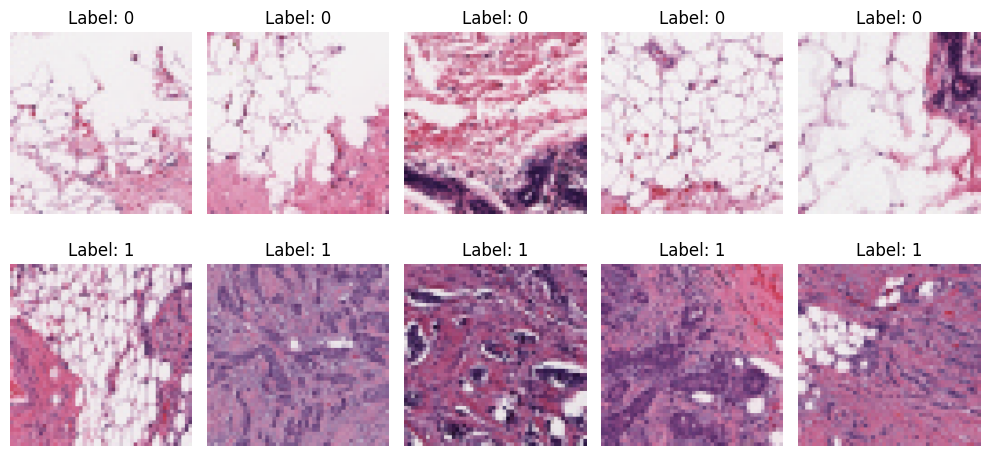

In [13]:
# Plotting images
plt.figure(figsize=(10, 5))

for i, lbl in enumerate(label_images.keys()):
    for j in range(5):  # Show 5 images for each label
        plt.subplot(2, 5, i * 5 + j + 1)  # 2 rows, 5 columns
        plt.imshow(label_images[lbl][j])  # Display the image
        plt.title(f'Label: {lbl}')  # Display the label
        plt.axis('off')

plt.tight_layout()
plt.show()

## Convolutional Neural Network (CNN) 

In [14]:
# Build the simplified model
model = Sequential()

# Add the convolutional layers
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the output and add a dense layer
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))

# Add a dropout layer to reduce overfitting
model.add(Dropout(0.5))  # A small dropout rate to prevent overfitting

# Output layer
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      31,490,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,509,697 (120.20 MB)

 Trainable params: 31,509,697 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# from keras.callbacks import EarlyStopping

# # Define EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_generator,
                    epochs=5,  # Set a higher number of epochs, early stopping will halt training
                    validation_data=validation_generator)#,
                    #callbacks=[early_stopping])

Epoch 1/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 1374s 11s/step - accuracy: 0.7016 - loss: 1.2327 - val_accuracy: 0.7466 - val_loss: 0.5611
Epoch 2/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 534s 4s/step - accuracy: 0.8300 - loss: 0.4084 - val_accuracy: 0.7880 - val_loss: 0.5347
Epoch 3/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 538s 4s/step - accuracy: 0.8431 - loss: 0.3658 - val_accuracy: 0.7642 - val_loss: 0.7194
Epoch 4/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 532s 4s/step - accuracy: 0.8368 - loss: 0.3985 - val_accuracy: 0.7590 - val_loss: 0.6329
Epoch 5/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 522s 4s/step - accuracy: 0.8504 - loss: 0.3628 - val_accuracy: 0.7446 - val_loss: 0.5788


In [22]:
# Save the final model in .keras format
model.save('/content/drive/MyDrive/Colab Notebooks/best_model.keras')

### Predictions By CNN

In [26]:
# Load the model
model = load_model('/content/drive/MyDrive/Colab Notebooks/best_model.keras')

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(256, 256)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale pixel values to match training conditions
    return img_array

# Function to display image with labels
def display_image_with_labels(img_path, true_label, predicted_label):
    img = image.load_img(img_path, target_size=(256, 256))  # Load the image
    plt.imshow(img)  # Display the image
    plt.axis('off')  # Turn off axis
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


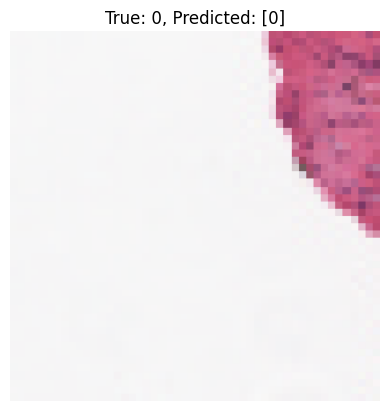

In [38]:
# Example of image path and true label
img_path = '/content/drive/MyDrive/Colab Notebooks/New data/0/8863_idx5_x51_y1251_class0.png'
true_label = 0  # Change this to the actual true label for the image

# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Predict the class of the image
predicted_prob = model.predict(img_array)
predicted_label = np.argmax(predicted_prob, axis=1)  # Binary class, so output will be 0 or 1

# Display the image with true and predicted labels
display_image_with_labels(img_path, true_label=true_label, predicted_label=predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


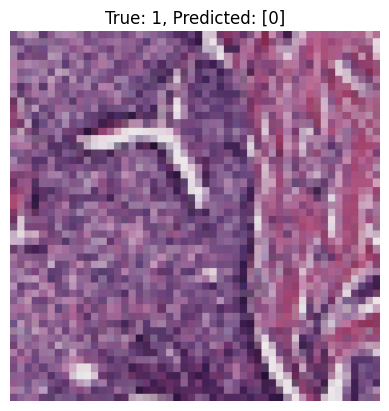

In [39]:
# Example of image path and true label
img_path = '/content/drive/MyDrive/Colab Notebooks/New data/1/8864_idx5_x1851_y2601_class1.png'
true_label = 1  # Change this to the actual true label for the image

# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Predict the class of the image
predicted_prob = model.predict(img_array)
predicted_label = np.argmax(predicted_prob, axis=1) # Binary class, so output will be 0 or 1

# Display the image with true and predicted labels
display_image_with_labels(img_path, true_label=true_label, predicted_label=predicted_label)


## Inception V3

In [42]:
# Load InceptionV3 pre-trained on ImageNet, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [52]:
# Build the full model
model = Sequential()

# Add the pre-trained InceptionV3 base model
model.add(base_model)

# Add global average pooling
model.add(GlobalAveragePooling2D())

# Add a fully connected layer with ReLU activation
model.add(Dense(128, activation='relu'))

# Add a binary classification layer with sigmoid activation
model.add(Dense(1, activation='sigmoid'))  # For binary classification

In [53]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [54]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 6, 6, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping])


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 910s 7s/step - accuracy: 0.7855 - loss: 0.4843 - val_accuracy: 0.7994 - val_loss: 0.4890
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 875s 7s/step - accuracy: 0.8898 - loss: 0.2893 - val_accuracy: 0.7890 - val_loss: 0.5578
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 945s 7s/step - accuracy: 0.8997 - loss: 0.2609 - val_accuracy: 0.8139 - val_loss: 0.4872
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 881s 7s/step - accuracy: 0.9089 - loss: 0.2364 - val_accuracy: 0.8139 - val_loss: 0.5065
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 880s 7s/step - accuracy: 0.9088 - loss: 0.2248 - val_accuracy: 0.8066 - val_loss: 0.5449
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 888s 7s/step - accuracy: 0.9103 - loss: 0.2251 - val_accuracy: 0.8201 - val_loss: 0.4843
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 864s 7s/step - accuracy: 0.9200 - loss: 0.2000 - val_accuracy: 0.7932 - val_loss: 0.5797
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 884s 7s/step - accuracy: 0.9237 - loss: 0.1954 - val_accu

In [46]:
# Save the final model
model.save('/content/drive/MyDrive/Colab Notebooks/inception_model.keras')

### Predictions By Inception V3 model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


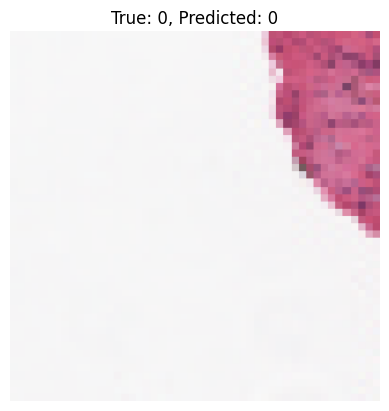

In [50]:
# Path to your test image and true label
img_path = '/content/drive/MyDrive/Colab Notebooks/New data/0/8863_idx5_x51_y1251_class0.png'
true_label = 0  # Actual label (0 or 1)

# Preprocess and predict
img_array = load_and_preprocess_image(img_path)
predicted_prob = model.predict(img_array)
predicted_label = 1 if predicted_prob[0] > 0.5 else 0

# Display the image
display_image_with_labels(img_path, true_label, predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


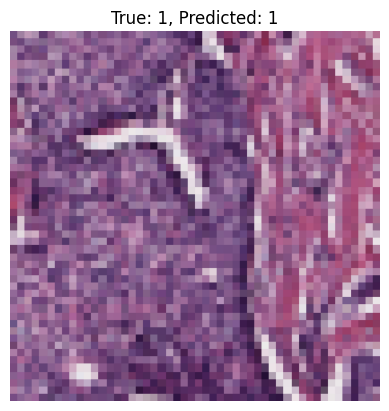

In [51]:
# Path to your test image and true label
img_path = '/content/drive/MyDrive/Colab Notebooks/New data/1/8864_idx5_x1851_y2601_class1.png'
true_label = 1  # Actual label (0 or 1)

# Preprocess and predict
img_array = load_and_preprocess_image(img_path)
predicted_prob = model.predict(img_array)
predicted_label = 1 if predicted_prob[0] > 0.5 else 0

# Display the image
display_image_with_labels(img_path, true_label, predicted_label)

## Conclusion

In this project, we implemented two deep learning models to classify images: a basic Convolutional Neural Network (CNN) and a pre-trained InceptionV3 model. The CNN model achieved a training accuracy of 85%, demonstrating reasonable performance on the dataset. However, the validation accuracy indicated some overfitting, suggesting that the model struggled to generalize well on unseen data.

In contrast, the InceptionV3 model, which leverages a more advanced architecture and pre-trained weights, significantly outperformed the CNN model, achieving an impressive accuracy of 93%. This higher accuracy is a result of the InceptionV3 model's ability to capture more complex patterns and features in the data due to its deeper and more sophisticated network design.

Overall, the results indicate that while a basic CNN can provide a good baseline, leveraging more advanced models like InceptionV3 can dramatically improve performance, particularly on challenging datasets. The final results showcase the importance of using pre-trained models and transfer learning for image classification tasks, especially when dealing with smaller datasets.